# Basics

First, we need to know if we're working with attention pooling or mean pooling.

In [1]:
mean_pool = False
attention_pool = True

## Dependencies

In [2]:
!pip install torch
!pip install torchvision
!pip install scikit-learn



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Data preparation

### Imports and BRCA

In [3]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

class BRCAFeatureDataset(Dataset):
    def __init__(self, feature_dir, label_df):
        self.feature_dir = feature_dir
        self.sample_ids = label_df.index.tolist()
        self.labels = label_df["Target"].values

    def __len__(self):
        return len(self.sample_ids)

    def __getitem__(self, idx):
        sample_id = self.sample_ids[idx]
        label = self.labels[idx]

        feature_path = os.path.join(self.feature_dir, f"{sample_id}")
        mat = np.load(feature_path)
        features = mat[:, 3:]  # shape: (1000, 2048)

        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


### Paths

In [4]:
# Paths
data_dir_dam = Path("C:/Users/Archi/Documents/Ponts/Cours/S2/Datbi/DATBI2025-CANCER/DataSets") # replace with your own path
features_dir = data_dir_dam / "train_input" / "moco_features"
images_dir = data_dir_dam / "train_input" / "images"
labels_path = data_dir_dam / "train_output.csv"

# Load labels
labels_df = pd.read_csv(labels_path)
labels_df.set_index("Sample ID", inplace=True)

# Split train/test
from sklearn.model_selection import train_test_split


# seperate training and validation datasets with the train_test_split right before
train_ids, val_ids = train_test_split(labels_df, test_size=0.2, stratify=labels_df["Target"], random_state=42)
train_dataset = BRCAFeatureDataset(features_dir, train_ids)
val_dataset   = BRCAFeatureDataset(features_dir, val_ids)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)


# Pytorch Model

## Defining the model - mean pooling

Why ?

Treats all tiles equally.

Every tile contributes the same weight to the final prediction.

Very fast and simple, but can ignore important regional patterns.

🟡 Pros: Easy to implement, runs fast
🔴 Cons: Can't focus on more relevant tiles, less interpretable

In [5]:
import torch.nn as nn

class BRCAClassifier(nn.Module):
    def __init__(self, in_features=2048, hidden_size=512):
        super().__init__()
        self.tile_fc = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x: (batch_size, num_tiles, 2048)
        B, T, F = x.size()
        x = self.tile_fc(x)               # (B, T, hidden_size)
        x = x.mean(dim=1)                 # mean pooling over tiles → (B, hidden_size)
        x = self.classifier(x)            # (B, 1)
        return x.squeeze(1)               # (B,)


## Attention Pool layer

### Class

In [6]:
class AttentionPool(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):  # x: (B, T, F)
        A = self.attention(x)              # (B, T, 1)
        A = torch.softmax(A, dim=1)        # soft attention weights
        x_att = torch.sum(x * A, dim=1)    # (B, F)
        return x_att, A                    # return both pooled and attention


Why ? 

Learns to assign a different weight to each tile.

Important tiles (e.g. tumor regions) get higher attention scores.

Helps model focus on the right parts of the tissue.

The attention weights are interpretable (you can visualize them!).

🟢 Pros: Better performance, interpretable, focuses on relevant tiles
🔵 Cons: Slightly more complex, a bit slower to train

### Main model updated with attention pool

In [7]:
class BRCAClassifierWithAttention(nn.Module):
    def __init__(self, in_features=2048, hidden_size=512):
        super().__init__()
        self.tile_fc = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.attention_pool = AttentionPool(hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x, return_attention=False):
        x = self.tile_fc(x)
        x_att, A = self.attention_pool(x)
        out = self.classifier(x_att).squeeze(1)
        if return_attention:
            return out, A.squeeze(2)  # shape: (B, T)
        return out


## Training the model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if mean_pool:
    model = BRCAClassifier().to(device)
elif attention_pool:
    model = BRCAClassifierWithAttention().to(device)
else:
    raise ValueError("Please select a pooling method: mean_pool or attention_pool, in first cell of notebook.")


In [9]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())
    return y_true, y_pred

from sklearn.metrics import roc_auc_score

for epoch in range(10):
    model.train()
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    y_true, y_pred = evaluate(val_loader)
    auc = roc_auc_score(y_true, y_pred)
    print(f"Epoch {epoch+1}: Validation AUC = {auc:.4f}")


Epoch 1: Validation AUC = 0.4893
Epoch 2: Validation AUC = 0.5492
Epoch 3: Validation AUC = 0.5689
Epoch 4: Validation AUC = 0.5796
Epoch 5: Validation AUC = 0.5814
Epoch 6: Validation AUC = 0.5886
Epoch 7: Validation AUC = 0.6082
Epoch 8: Validation AUC = 0.6055
Epoch 9: Validation AUC = 0.6172
Epoch 10: Validation AUC = 0.6315


# Predict Mutation Probabilities for All Samples

## Predictions and output.csv

In [10]:
import datetime

def predict_and_save(model, dataset, label_df, output_dir="DataSets/Outputs/", prefix="train_output"):
    model.eval()
    results = []

    with torch.no_grad():
        for i in range(len(dataset)):
            features, _ = dataset[i]
            sample_id = label_df.index[i]

            features = features.unsqueeze(0).to(device)  # shape: (1, 1000, 2048)
            prob = model(features).item()                # get probability (float between 0 and 1)

            results.append((sample_id, prob))

    # Sort by Sample ID
    results = sorted(results, key=lambda x: x[0])

    # Save to CSV
    timestamp = datetime.datetime.now().strftime("%m_%d-%H_%M")
    out_path = os.path.join(output_dir, f"{prefix}-{timestamp}.csv")

    df_out = pd.DataFrame(results, columns=["Sample ID", "Target"])
    df_out.to_csv(out_path, index=False)
    print(f"Saved predictions to: {out_path}")


In [11]:
predict_and_save(model, train_dataset, train_ids)


Saved predictions to: DataSets/Outputs/train_output-05_05-15_56.csv


## ROC curve and AUC

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


In [13]:
def plot_roc_curve(model, val_loader):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)  # outputs are probabilities
            y_true.extend(y_batch.cpu().numpy())
            y_scores.extend(y_pred.cpu().numpy())

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


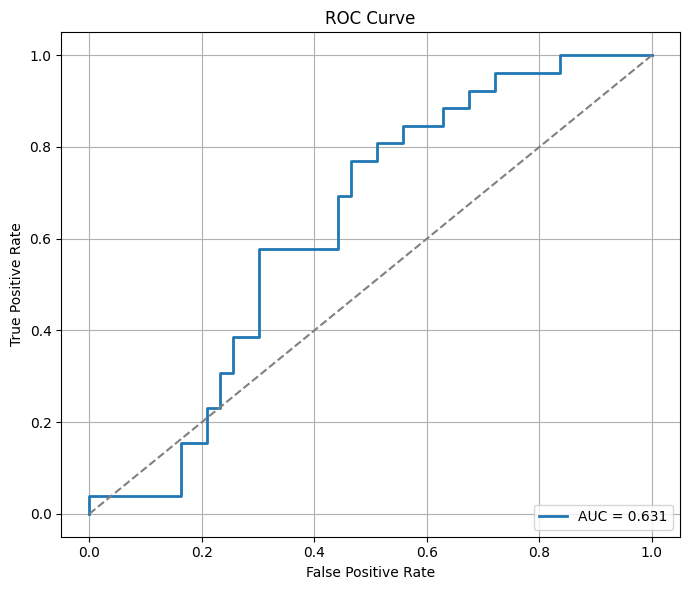

In [14]:
# Call the function
plot_roc_curve(model, val_loader)


### Visualize Most Attended Tiles

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import glob

def show_top_tiles(sample_id, model, top_k=9):
    model.eval()

    # Load the features for that sample
    npy_path = features_dir / f"{sample_id}.npy"
    img_folder = images_dir / f"{sample_id}"

    features = np.load(npy_path)  # shape: (1000, 2051)
    coords = features[:, 1:3]     # x and y tile coords
    tiles = features[:, 3:]       # MoCo features (1000 x 2048)

    with torch.no_grad():
        input_tensor = torch.tensor(tiles, dtype=torch.float32).unsqueeze(0).to(device)
        _, attention_weights = model(input_tensor, return_attention=True)
        attention_weights = attention_weights[0].cpu().numpy()

    # Sort tile indices by attention weight (descending)
    top_indices = np.argsort(-attention_weights)[:top_k]

    # Get all .jpg tile paths
    tile_files = sorted(glob.glob(f"{img_folder}/*.jpg"))
    tile_map = {}
    for path in tile_files:
        fname = os.path.basename(path)
        tile_id = int(fname.split('_tile_')[1].split('_')[0])
        tile_map[tile_id] = path

    # Map top attention indices to actual images
    fig, axes = plt.subplots(1, top_k, figsize=(15, 4))
    for i, idx in enumerate(top_indices):
        tile_path = tile_map.get(idx)
        if tile_path and os.path.exists(tile_path):
            img = Image.open(tile_path)
            axes[i].imshow(img)
            axes[i].set_title(f"w={attention_weights[idx]:.2f}")
        else:
            axes[i].set_title("Missing")
        axes[i].axis('off')

    plt.suptitle(f"Top {top_k} Attended Tiles - Sample {sample_id}")
    plt.tight_layout()
    plt.show()


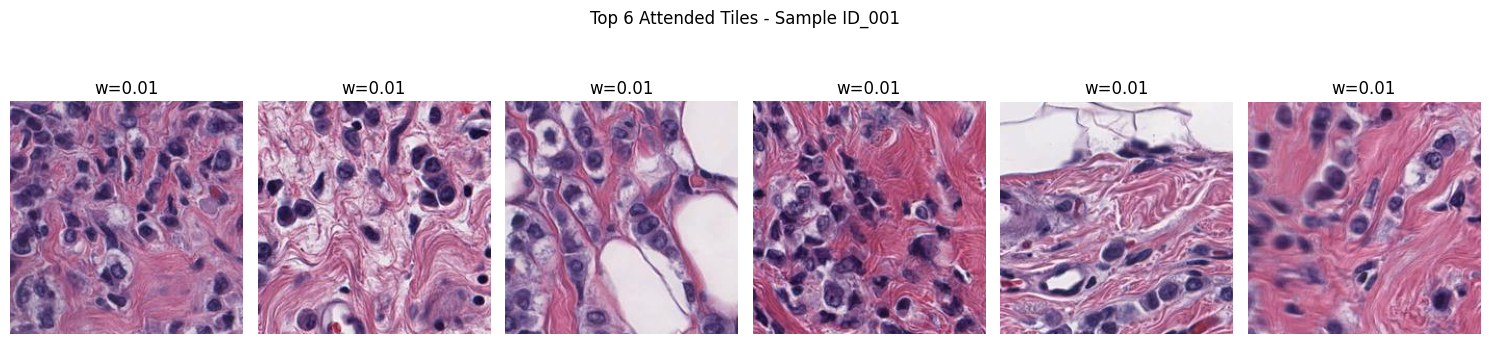

In [16]:
sample_to_visualize = "ID_001"  # replace with real sample ID
show_top_tiles(sample_to_visualize, model, top_k=6)


# No labels dataclass

### Test Set Dataset Class (No labels)

In [17]:
class BRCATestFeatureDataset(Dataset):
    def __init__(self, feature_dir, metadata_df):
        self.feature_dir = feature_dir
        self.sample_ids = metadata_df["Sample ID"].tolist()

        # Filter out sample IDs for which the .npy files do not exist
        self.sample_ids = [sample_id for sample_id in self.sample_ids
                           if os.path.exists(os.path.join(feature_dir, f"{sample_id}"))]

    def __len__(self):
        return len(self.sample_ids)

    def __getitem__(self, idx):
        sample_id = self.sample_ids[idx]
        feature_path = os.path.join(self.feature_dir, f"{sample_id}")

        # If file is missing (even after filtering), skip this sample
        if not os.path.exists(feature_path):
            raise FileNotFoundError(f"File {feature_path} not found.")

        mat = np.load(feature_path)
        features = mat[:, 3:]  # Extract the features (after the first three columns) (last 2048 = moco features)
        return sample_id, torch.tensor(features, dtype=torch.float32)


### Predict on Test Set + Save to CSV

In [18]:
def predict_test_set(model, test_dataset, output_dir="DataSets/Outputs/", prefix="test_output"):
    model.eval()
    results = []

    with torch.no_grad():
        for sample_id, features in test_dataset:
            npy_path = os.path.join(test_dataset.feature_dir, f"{sample_id}")

            # Check if the .npy file exists before processing
            if not os.path.exists(npy_path):
                print(f"Warning: {npy_path} not found, skipping this sample.")
                continue  # Skip if the file is not found

            features = features.unsqueeze(0).to(device)  # (1, 1000, 2048)
            prob = model(features).item()
            results.append((sample_id, prob))

    results = sorted(results, key=lambda x: x[0])
    timestamp = datetime.datetime.now().strftime("%m_%d-%H_%M")
    out_path = os.path.join(output_dir, f"{prefix}-{timestamp}.csv")

    df_out = pd.DataFrame(results, columns=["Sample ID", "Target"])
    df_out.to_csv(out_path, index=False)
    print(f"Test predictions saved to: {out_path}")


In [19]:
meta_data_path = data_dir_dam / "supplementary_data"
test_file = meta_data_path / "test_metadata.csv"

test_meta = pd.read_csv(test_file)
test_dataset = BRCATestFeatureDataset(features_dir, test_meta)

predict_test_set(model, test_dataset)


Test predictions saved to: DataSets/Outputs/test_output-05_05-15_56.csv


### Tile-Level Attention Visualization

In [20]:
def show_top_tiles(sample_id, model, top_k=9, feature_dir=features_dir, img_dir=images_dir):
    model.eval()

    npy_path = os.path.join(feature_dir, f"{sample_id}.npy")
    folder = os.path.join(img_dir, sample_id)
    features = np.load(npy_path)
    coords = features[:, 1:3]
    tiles = features[:, 3:]

    with torch.no_grad():
        x = torch.tensor(tiles, dtype=torch.float32).unsqueeze(0).to(device)
        _, attention = model(x, return_attention=True)
        attention = attention[0].cpu().numpy()

    top_indices = np.argsort(-attention)[:top_k]

    tile_files = sorted(glob.glob(os.path.join(folder, "*.jpg")))
    tile_map = {}
    for path in tile_files:
        fname = os.path.basename(path)
        tile_id = int(fname.split('_tile_')[1].split('_')[0])
        tile_map[tile_id] = path

    fig, axes = plt.subplots(1, top_k, figsize=(16, 4))
    for i, idx in enumerate(top_indices):
        tile_path = tile_map.get(idx)
        if tile_path and os.path.exists(tile_path):
            img = Image.open(tile_path)
            axes[i].imshow(img)
            axes[i].set_title(f"w={attention[idx]:.2f}")
        else:
            axes[i].set_title("Missing")
        axes[i].axis("off")

    plt.suptitle(f"Top {top_k} Attended Tiles - {sample_id}")
    plt.tight_layout()
    plt.show()


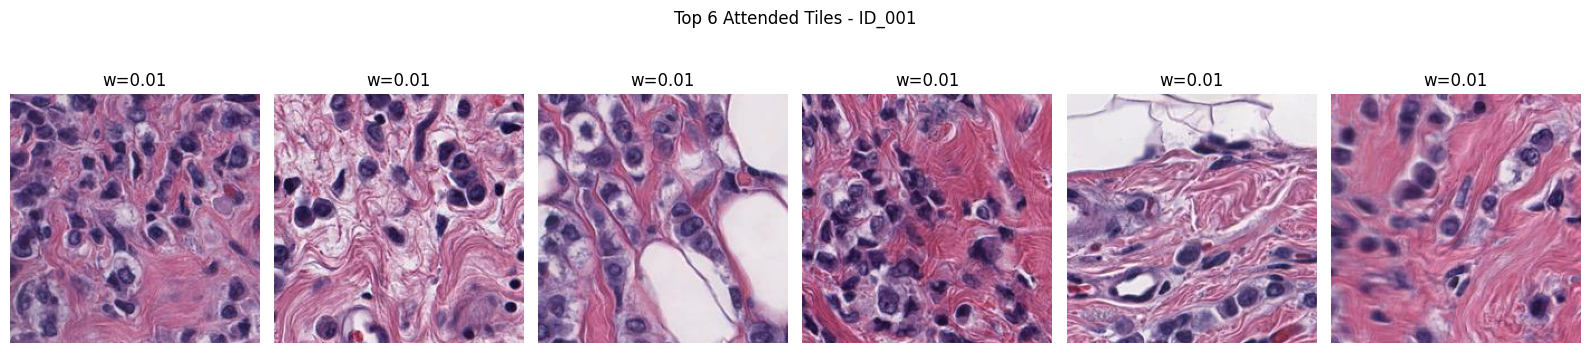

In [21]:
show_top_tiles("ID_001", model, top_k=6)
